<a href="https://colab.research.google.com/github/ilanmoshe52/Final_Project/blob/main/homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import zipfile
import os
import cv2
import matplotlib.pyplot as plt
from skimage import io
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [167]:
def dice_coefficient(gt_image, seg_image):
    intersection = np.logical_and(gt_image, seg_image).sum()
    union = gt_image.sum() + seg_image.sum()
    dice = (2. * intersection) / union
    return dice

def jaccard_index(gt_image, seg_image):
    intersection = np.logical_and(gt_image, seg_image).sum()
    union = np.logical_or(gt_image, seg_image).sum()
    jaccard = intersection / union
    return jaccard

def precision_recall(gt_image, seg_image):
    tp = np.logical_and(gt_image, seg_image).sum()
    fp = np.logical_and(np.logical_not(gt_image), seg_image).sum()
    fn = np.logical_and(gt_image, np.logical_not(seg_image)).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall, 2 * precision * recall / (precision + recall)


def get_ground_truth(file_name):
    segmentation = []

    # Load the ground truth file (.mat) from BSDS
    mat_file = '/content/ground/' + file_name[:-3]+'mat'
    data = loadmat(mat_file)
    #header = data['groundTruth']
    ground_truths = data['groundTruth']
    #gt_image = header[0,0][0][0][0]
    #for i, gt in enumerate(ground_truths[0]):
    #  segmentation[i] = gt['Segmentation'][0, 0]
    #  boundaries = gt['Boundaries'][0, 0]
    #continue;

    return ground_truths[0]

In [131]:
# Path to the partial dataset zip file
zip_file_path = '/content/Berkeley_Segmentation_Dataset_(Partial).zip'
zip_ground_path = '/content/Berkley_Ground_Truth.zip'

# Directory to extract files
extract_dir = '/content/images'
extract_dir_ground = '/content/ground'

# Unzip the images files
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Unzip the images files
with zipfile.ZipFile(zip_ground_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_ground)


In [132]:
# Create a DataFrame with the specified columns
csv_file = 'segmentation_metrics.csv'
columns = ['image_name' , 'dice', 'precision', 'Jaccard', 'F1', 'Recall']
df = pd.DataFrame(columns=columns)
df.head()

,image_name,dice,precision,Jaccard,F1,Recall


In [181]:
def add_record(file , y_pred , type ):

        global df
        j = 0

        # write the resuls
        ground_truths = get_ground_truth(file)
        jaccard = np.zeros(len(ground_truths))
        precision = np.zeros(len(ground_truths))
        recall = np.zeros(len(ground_truths))
        f_measure = np.zeros(len(ground_truths))
        dice = np.zeros(len(ground_truths))

        print(file + str(len(ground_truths)))

        for i, gt in enumerate(ground_truths):
          segmentation = gt['Segmentation'][0, 0]
          boundaries = gt['Boundaries'][0, 0]

          if type == 'Cluster' or type == 'Threshold':
            y_true = segmentation
          elif type == 'Edge':
            y_true = boundaries

          print(y_true.shape)
          #normalize the images
          y_true = (y_true > 0).astype(np.uint8)
          y_pred = (y_pred > 0).astype(np.uint8)

          # perform statistics tests
          jaccard[j]  = jaccard_score(y_true, y_pred , average='micro', zero_division=0)
          precision[j] = precision_score(y_true, y_pred,average='micro' , zero_division=0)
          recall[j]    = recall_score(y_true, y_pred, average='micro' , zero_division=0)
          f_measure[j] = f1_score(y_true, y_pred , average='micro', zero_division=0)
          dice[j]      = dice_coefficient(y_true, y_pred)
          j += 1

        rows = []

        row = {
          'image_name'  : str(file[:-4]) + '(' + str(type) + ')',
          'dice'        : np.max(dice),
          'precision'   : np.max(precision),
          'Jaccard'     : np.max(jaccard),
          'F1'          : np.max(f_measure),
          'Recall'      : np.max(recall) }

        rows.append(row)
        rows_df = pd.DataFrame(rows)
        df = pd.concat([df, rows_df], ignore_index=True)


23080.jpg5
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
23080.jpg5
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
23080.jpg5
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)


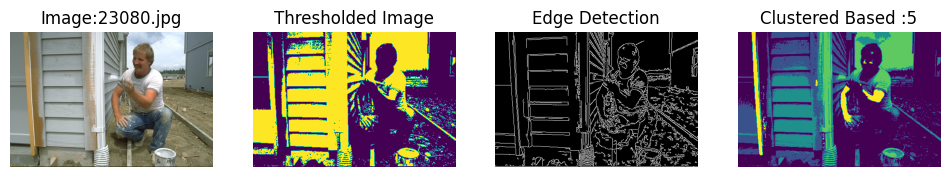

15004.jpg6
(481, 321)
(481, 321)
(481, 321)
(481, 321)
(481, 321)
(481, 321)
15004.jpg6
(481, 321)
(481, 321)
(481, 321)
(481, 321)
(481, 321)
(481, 321)
15004.jpg6
(481, 321)
(481, 321)
(481, 321)
(481, 321)
(481, 321)
(481, 321)


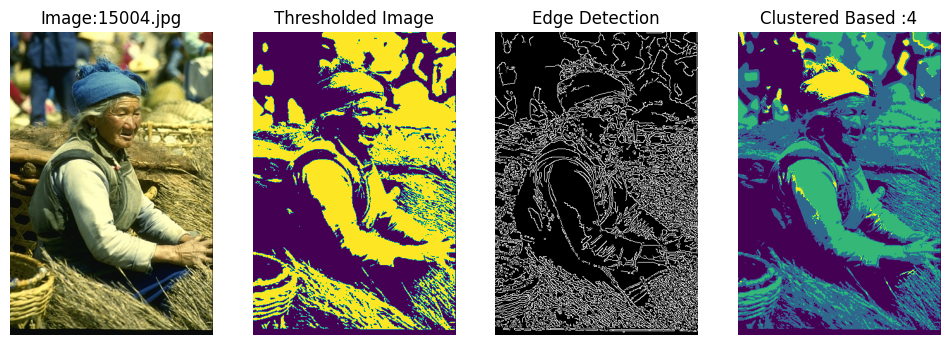

33066.jpg5
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
33066.jpg5
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
33066.jpg5
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)


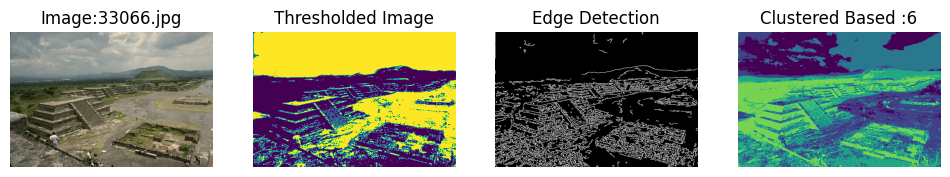

16052.jpg6
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
16052.jpg6
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)


KeyboardInterrupt: 

In [182]:
# Loop through the directory , read files , and perform three different image segmentation techniques
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        file_path = os.path.join(root, file)
        image = io.imread(file_path)

        # convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # calculate and apply adaptive threshold for every image
        channel_threshold = 0
        channel_threshold = np.mean(gray_image)
        _, thresholded_image = cv2.threshold(gray_image,channel_threshold, 255, cv2.THRESH_BINARY)

        add_record(file , thresholded_image , 'Threshold' )

        # Apply Canny edge detection
        edges = cv2.Canny((image * 255).astype('uint8'), 100, 200)

        add_record(file , edges , 'Edge' )

        # Clustering-based segmentation ( Mean Shift)
        # Reshape the image to a 2D array of pixels
        flat_image = image.reshape((-1, 3))

        # Estimate the bandwidth of the data
        bandwidth = estimate_bandwidth(flat_image, quantile=0.1, n_samples=500)

        # Perform Mean Shift clustering
        mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        mean_shift.fit(flat_image)
        labels = mean_shift.labels_

        # Number of clusters
        num_clusters = len(np.unique(labels))

        # Reshape the labels to the original image shape
        segmented_image = labels.reshape(image.shape[:2])

        add_record(file , segmented_image , 'Cluster')

        # Display the images
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 4, 1)
        plt.title('Image:'+str(file))
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title('Thresholded Image')
        plt.imshow(thresholded_image, cmap='viridis')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title('Edge Detection')
        plt.imshow(edges, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title('Clustered Based :' + str(num_clusters))
        plt.imshow(segmented_image, cmap='viridis')
        plt.axis('off')
        plt.show()

# print the results
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(df)

In [122]:
# DEBUG

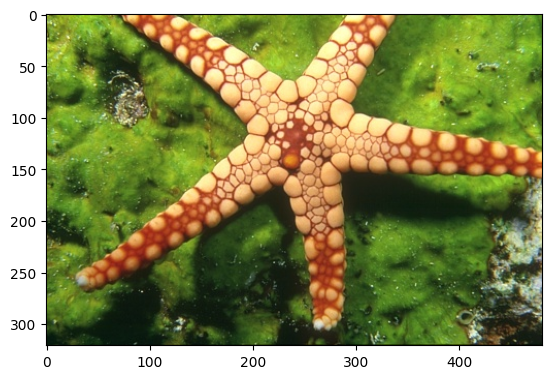

In [123]:
# Directory to extract files
extract_dir = '/content/images/12003.jpg'
image = io.imread(extract_dir)
plt.imshow(image)

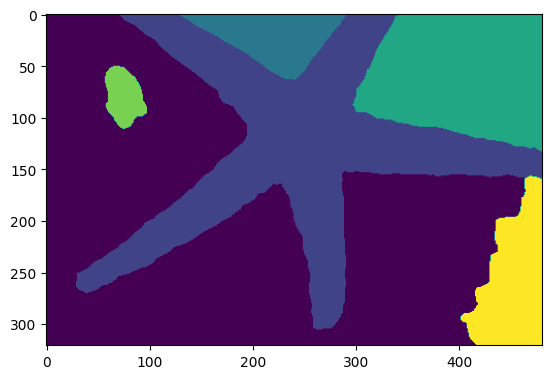

In [104]:
mat_file = '/content/ground/12003.mat'
data = loadmat(mat_file)
header = data['groundTruth']
gt_image = header[0,0][0][0][0]
plt.imshow(gt_image)

[1 2 3 4 5 6]
{1: 80095, 2: 39956, 3: 5646, 4: 19146, 5: 1714, 6: 7844}
(321, 481)
[1 2 3 4 5 6]
{1: 79739, 2: 40006, 3: 5562, 4: 19264, 5: 1646, 6: 8184}
(321, 481)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98]
{1: 32653, 2: 49, 3: 148, 4: 1946, 5: 62, 6: 5595, 7: 189, 8: 508, 9: 142, 10: 19079, 11: 126, 12: 333, 13: 133, 14: 253, 15: 131, 16: 10886, 17: 150, 18: 162, 19: 285, 20: 263, 21: 184, 22: 304, 23: 210, 24: 346, 25: 315, 26: 2, 27: 279, 28: 1652, 29: 305, 30: 355, 31: 367, 32: 395, 33: 334, 34: 395, 35: 20, 36: 18, 37: 347, 38: 477, 39: 390, 40: 345, 41: 379, 42: 3, 43: 405, 44: 1, 45: 351, 46: 2820, 47: 307, 48: 281, 49: 237, 50: 303, 51: 179, 52: 141, 53: 291, 54: 273, 55: 304, 56: 2, 57: 277, 58: 1, 59: 255, 60: 269, 61: 16

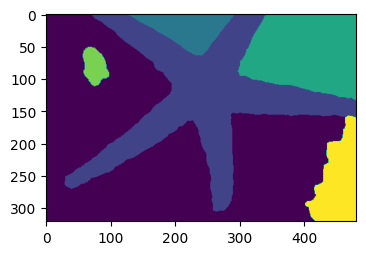

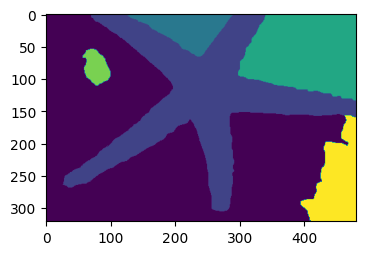

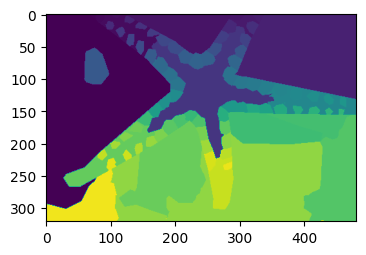

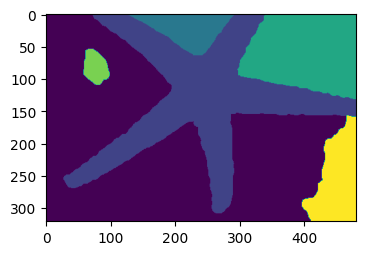

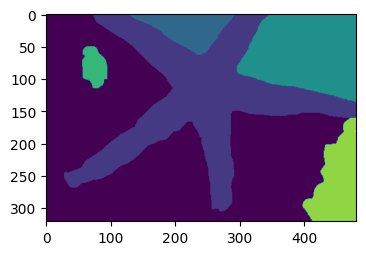

In [109]:
for i in range(len(header[0])):
  gt_image = header[0,i][0][0][0]
  plt.figure(i,figsize=(4,3))
  plt.imshow(gt_image)
  unique_elements, counts = np.unique(gt_image, return_counts=True)
  print(unique_elements)
  # Combine unique elements and their counts into a dictionary
  element_counts = dict(zip(unique_elements, counts))
  print(element_counts)
  print(gt_image.shape)

In [124]:
header

array([[array([[(array([[1, 1, 1, ..., 4, 4, 4],
                       [1, 1, 1, ..., 4, 4, 4],
                       [1, 1, 1, ..., 4, 4, 4],
                       ...,
                       [1, 1, 1, ..., 6, 6, 6],
                       [1, 1, 1, ..., 6, 6, 6],
                       [1, 1, 1, ..., 6, 6, 6]], dtype=uint16), array([[0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       ...,
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))                                 ]],
              dtype=[('Segmentation', 'O'), ('Boundaries', 'O')])                                 ,
        array([[(array([[1, 1, 1, ..., 4, 4, 4],
                       [1, 1, 1, ..., 4, 4, 4],
                       [1, 1, 1, ..., 4, 4, 4],
                       ...,
                       [1, 1, 1, ..., 6, 6,

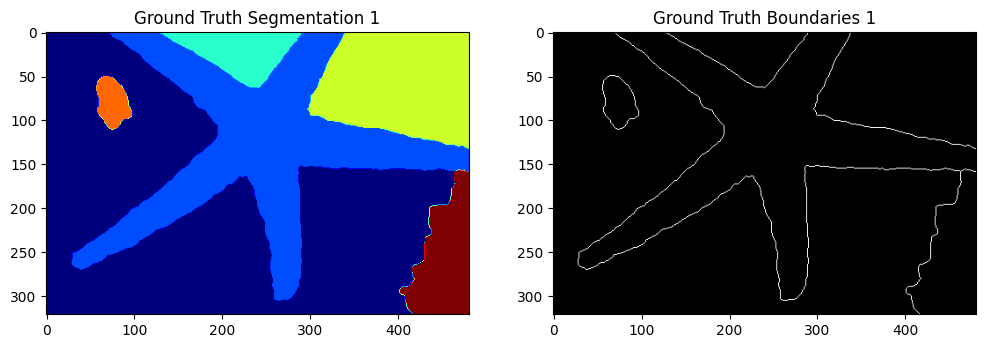

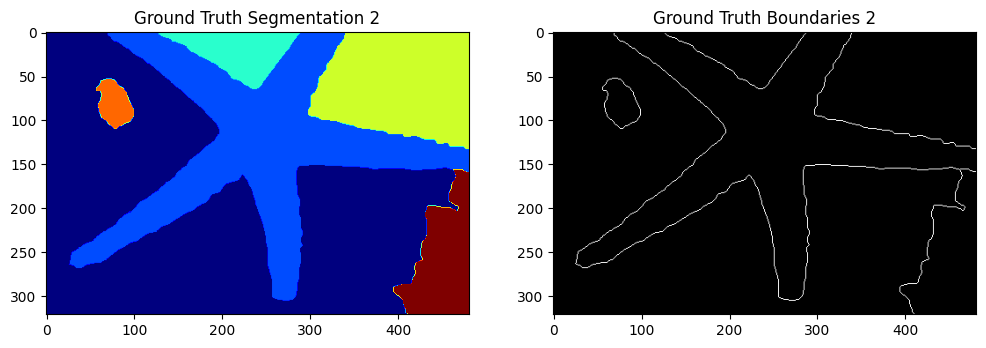

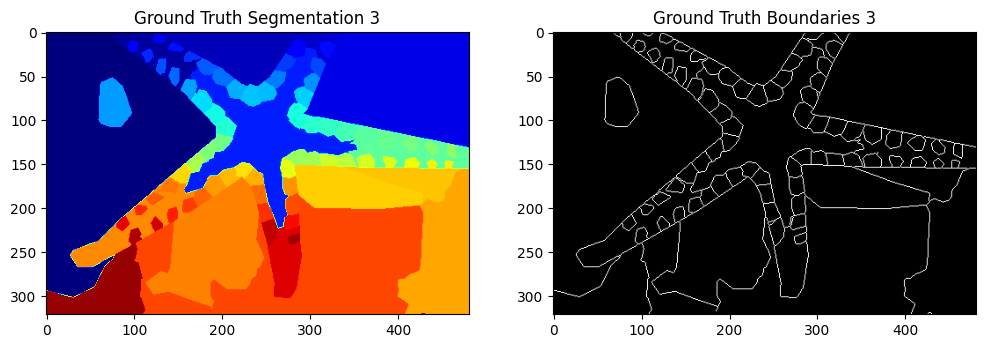

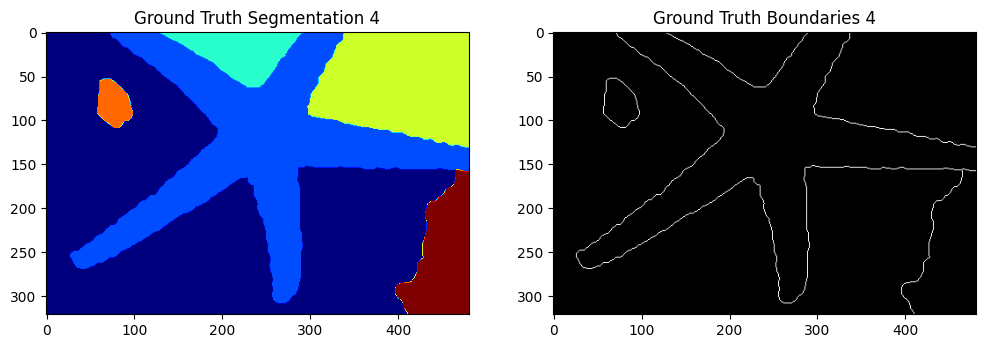

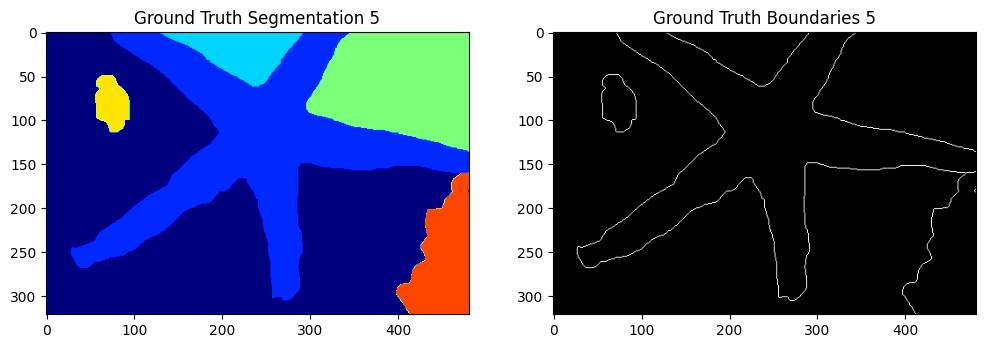

In [125]:
import scipy.io as sio
import matplotlib.pyplot as plt

# Load the ground truth .mat file
mat_file_path = '/content/ground/12003.mat'
data = sio.loadmat(mat_file_path)

# Access the groundTruth cell array
ground_truths = data['groundTruth']

# Iterate through each ground truth segmentation
for i, gt in enumerate(ground_truths[0]):
    segmentation = gt['Segmentation'][0, 0]
    boundaries = gt['Boundaries'][0, 0]

    # Display the segmentation
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f'Ground Truth Segmentation {i+1}')
    plt.imshow(segmentation, cmap='jet')

    # Display the boundaries
    plt.subplot(1, 2, 2)
    plt.title(f'Ground Truth Boundaries {i+1}')
    plt.imshow(boundaries, cmap='gray')

    plt.show()
